# Training Simple CNN on the MNIST Dataset - Handwritten Digits

# 1. Import modules and check GPU availability

In [1]:
import torch

# We use torchvision to get our dataset and useful image transformations
import torchvision
import  torchvision.transforms as transforms

# Import Pytorch's optimization library and nn
# nn is used as the basic building block for our Network graphs
import torch.optim as optim
from torch import nn
import torch.nn.functional as F

import cv2
import numpy as np
from matplotlib import pyplot as plt

In [2]:
GPU_IS_AVAILABLE = torch.mps.is_available()
GPU_DEVICE = torch.device("mps") if GPU_IS_AVAILABLE else torch.device("cpu")

print("GPU available: {}".format(GPU_IS_AVAILABLE))
print("Using device: {}".format(GPU_DEVICE))

GPU available: True
Using device: mps



# 2. Define Transformer

Transfomers are needed to cast the image data into the required format for input into our model.

- It's composed using the ```transforms.Compose``` function
- We chain the commands or instructions for our pipeline as the arguements
- We use ```transforms.ToTensor()``` to convert the image data into a PyTorch Tensor
- We use ```transforms.Normalize()``` to normalize our pixel values
- By passing the input as ```(0.5, ), (0.5,)``` we Normalize our image data between -1 and +1 
- Note for RGB images we use ```transformed.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))``` instead

**NOTE**:
Our raw pixel values in our MNIST dataset range from 0 to 255. Each image is 28 pixels heigh and 28 pixels wide, with a depth of 1 as it's grayscale.

**Why Normalize?**

1. To ensure all features, or in our case, pixel intensities, are weighted equally when training our CNN
2. Makes training faster as it avoids oscilations during training
3. Removes and bias or skewness in our image data


**Why 0.5?**

Normalization is done like this:

`image = (image - mean) / std`

Using the parameters 0.5,0.5 sets the Mean and STD to 0.5. Using the formula above this gives us:

- Min value = `(0-0.5)/0.5 = 1`
- Max value = `(1-0.5)/0.5 = -1`

For color images we use a tuple of (0.5,0.5,0.5) to set the Mean of the RGB channels to 0.5 and another tuple of (0.5, 0.5, 0.5) to set the STD to 0.5

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) # (0.5,) is to define tuple with single value, (0.5) is just a float
])

# 3. Fetch MNIST Dataset using Torchvision

In [4]:
# Load training dataset
train_set = torchvision.datasets.MNIST(
    "dataset/train",
    train=True,
    download=True,
    transform=transform,
)

# Load test dataset
test_set = torchvision.datasets.MNIST(
    "dataset/test",
    train=False,
    download=True,
    transform=transform,
)

# 4 Inspect Dataset

In [5]:
# Here we already have relatively ideal dataset splitting (6:1)
print(train_set.data.shape)
print(test_set.data.shape)

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


In [6]:
print(train_set.data[0].shape)
print(train_set.data[0])

torch.Size([28, 28])
tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,  

## 4.2 Plot the image with OpenCV

In [7]:
# Define imshow function
def imshow(title="", image=None, size=6):
    w, h = image.shape[0], image.shape[1]
    aspect_ratio = w/h
    plt.figure(figsize=(size*aspect_ratio, size))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.show()

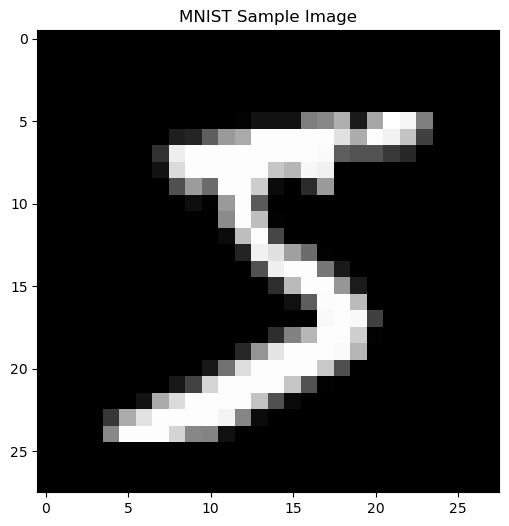

In [8]:
image = train_set.data[0].numpy()
imshow("MNIST Sample Image", image)

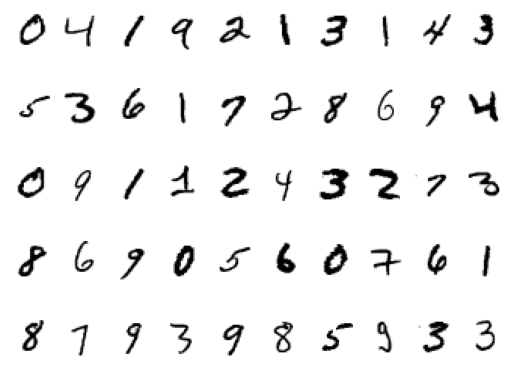

In [9]:
# View 50 first images of the MNIST training set
figure = plt.figure()
num_of_images =  50

for index in range(1, num_of_images + 1):
    plt.subplot(5, 10, index)
    plt.axis("off")
    plt.imshow(train_set.data[index], cmap="gray_r")

# 5 Create Data Loader

A **Data Loader** is a function that we'll use to grab our data in specified batch sizes (we'll use 128) during training. 

Remember we can't feed all our data through the network at once, therefore that is why we split data into batches. 

We set **shuffle** equal to True to prevent data sequence bias. For example, in some datasets the each class in usually in order, so to avoid loading batches of only a single class, we shuffle our data.

```num_workers``` specifies how many CPU cores we wish to utilize, setting it 0 means that it will be the main process that will do the data loading when needed. Leave it as 0 unless you wish to experiment futher.

In [10]:
# Prepare train and test loaders
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=128,
    shuffle=True,
    num_workers=0,
)

test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=128,
    shuffle=True,
    num_workers=0,
)

## 5.1 Using iter and next for batches loading

In [11]:
# Use the the Python function iter to return an iterator for our train_loader object
data_iter = iter(train_loader)

# Use .next() to get the first batch of data from our iterator
images, labels = next(data_iter)

print(images.shape)
print(labels.shape)

torch.Size([128, 1, 28, 28])
torch.Size([128])


## 5.2 Plot Batches with Pytorch

In [12]:
def batchshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

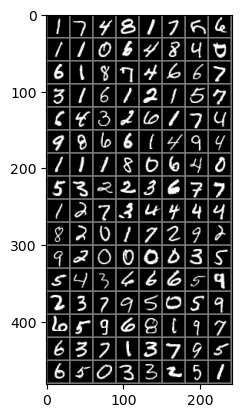

17481756110648406187466731612157643261749866149411180640532236771273444482017292920000355436665923795059659681976371379565033251


In [13]:
# Show images
batchshow(torchvision.utils.make_grid(images))

# Print labels
print("".join("%1s" %labels[j].numpy() for j in range(128)))

# 6. Build CNN Model

# **6. Now we build our Model**

We will use the ```nn.Sequential``` method to construct our model. Alernatively we can use the functional module, however this is simpler and more similar to styles you'll work with in Keras.

### **Building a Convolution Filter Layer**

```
nn.Conv2d(in_channels=1,
          out_channels=32,
          kernel_size=3,
          stride=1, 
          padding=1)
```

- **in_channels (int)** — This is the number of channels in the input image (for grayscale images use 1 and for RGB color images use 3)
- **out_channels (int)** — This is the number of channels produced by the convolution. We use 32 channels or 32 filters. **NOTE** 32 will be the number of **in_channels** in the next network layer.
- **kernel_size (int or tuple)** — This is the size of the convolving kernel. We use 3 here, which gives a kernel size of 3 x 3.
- **stride (int or tuple, optional)** — Stride of the convolution. (Default: 1)
- **padding (int or tuple, optional)** — Zero-padding added to both sides of the input (Default: 0). We use a padding = 1.

### **The Max Pool Layer**

- Each pooling layer i.e., nn.MaxPool2d(2, 2) halves both the height and the width of the image, so by using 2 pooling layers, the height and width are 1/4 of the original sizes.

![](https://github.com/rajeevratan84/ModernComputerVision/raw/main/CleanShot%202020-11-29%20at%204.21.04%402x.png)

**torch.nn.functional**

Generally imported into the namespace F by convention, this module contains all the functions in the torch.nn library (whereas other parts of the library contain classes). As well as a wide range of loss and activation functions, you’ll also find here some convenient functions for creating neural nets, such as pooling functions. (There are also functions for doing convolutions, linear layers, etc, but as we’ll see, these are usually better handled using other parts of the library.)

In [14]:
# Create CNN model
class Net(nn.Module):
    def __init__(self):
        # super is a subcclass of the nn.Module and inherits all its methods
        super(Net, self).__init__()
        
        # Define layer objects here
        # First Conv layer: 32 filter of 3x3 kernel, stride 1, padding 0
        self.conv1 = nn.Conv2d(1, 32, 3)
        # Second Conv layer: 64 filter of 3x3 kernel, stride 1, padding 0
        self.conv2 = nn.Conv2d(32, 64, 3)
        # Max pooling layer: 2x2 kernel, stride 2
        self.pool = nn.MaxPool2d(2, 2)
        # First FC layer, takes the output of the max pool layer
        # which is 64 x 12 x 12 and connects it to a set of 128 nodes
        self.fc1 = nn.Linear(64*12*12, 128)
        # Second FC layer, connects the 128 nodes to 10 output nodes (output classes)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        # Forward propagation sequence
        # Conv1 -> RELU -> Conv2 -> RELU -> Max Pool -> Flattern -> FC1 -> FC2
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 64*12*12) # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [15]:
net = Net()
net.to(GPU_DEVICE)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

# 7. Define Loss Function and Optimizer

In [16]:
# Use Cross Entropy Loss as loss function
criterion = nn.CrossEntropyLoss()

# Use Stochastic Gradient Descent (SGD) as optimizer
# Use SGD with learning rate of 0.001 and momentum of 0.9
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# 8. Train CNN Model

![](https://github.com/rajeevratan84/ModernComputerVision/raw/main/CleanShot%202020-11-29%20at%207.04.32%402x.png)

In [17]:
# Loop over the training set multiple times (each time is called an epoch)
epochs = 10

# Create some empty arrays to store logs
epoch_log = []
loss_log = []
accuracy_log = []

# Iterate for a specified number of epochs
for epoch in range(epochs):
    print(f"Starting Epoch: {epoch+1}")
    
    # Keep adding or accumulating our loss after each mini-batch in running_loss
    running_loss = 0.0
    
    # Iterate through our train_loader iterator, where each cycle is a mini-batch
    for i, data in enumerate(train_loader, 0):
        # Get the inputs: data is a list of [inputs, labels]
        inputs, labels = data
        
        # Send our train data to GPU
        inputs = inputs.to(GPU_DEVICE)
        labels = labels.to(GPU_DEVICE)
        
        # Clear the gradients before training by setting to zero (required for fresh start)
        optimizer.zero_grad()
        
        # Forward -> back-propagation + optimize
        outputs = net(inputs) # Forward propagation
        loss = criterion(outputs, labels) # Get loss value (quantify the difference between the results and predictions)
        loss.backward() # Back-propagate to obtain the new gradients for all nodes
        optimizer.step() # Update the gradients/weights
        
        # Print training statistics - epochs/iterations/loss/accuracy
        running_loss += loss.item() # Add loss to running_loss
        if i % 50 == 49: # Show loss value every 50 mini-matches
            correct = 0 # Initialize variable to hold the count for the correct predictions
            total = 0 # Initialize variable to hold the count of the number of labels iterated
            
            # We don't need gradients for validation, so wrap in .no_grad to save memory
            with torch.no_grad(): # Disable the tracking of any calculations required to later calculate a gradient
                for data in test_loader:
                    images, labels = data
                    
                    # Send our test data to GPU
                    images = images.to(GPU_DEVICE)
                    labels = labels.to(GPU_DEVICE)
                    
                    # Forward propagate our test data batch through our model
                    outputs = net(images)
                    
                    # Get predictions from the maximum value of the predicted output tensor (maximum probability).
                    # We set dim=1 as it specifies the number of dimensions to reduce
                    _, predicted = torch.max(outputs.data, dim=1) 
                    # Keep adding the label size or length to the total variable
                    total += labels.size(0)
                    # Keep a running total of the number of predictions predicted correctly
                    correct += (predicted == labels).sum().item()
                
                accuracy = 100 * (correct / total)
                epoch_num =   epoch + 1
                actual_loss = running_loss / 50
                print(f"Epoch: {epoch_num}, Mini-Batches Completed: {(i+1)}, Loss: {actual_loss:.3f}, Test Accuracy = {accuracy:.3f}%")
                running_loss = 0.0
    
    # Store training stats after each epoch
    epoch_log.append(epoch_num)
    loss_log.append(actual_loss)
    accuracy_log.append(accuracy)

print("Finished Training!")

Starting Epoch: 1
Epoch: 1, Mini-Batches Completed: 50, Loss: 2.274, Test Accuracy = 26.530%
Epoch: 1, Mini-Batches Completed: 100, Loss: 2.143, Test Accuracy = 58.520%
Epoch: 1, Mini-Batches Completed: 150, Loss: 1.697, Test Accuracy = 75.450%
Epoch: 1, Mini-Batches Completed: 200, Loss: 0.896, Test Accuracy = 82.170%
Epoch: 1, Mini-Batches Completed: 250, Loss: 0.553, Test Accuracy = 86.870%
Epoch: 1, Mini-Batches Completed: 300, Loss: 0.467, Test Accuracy = 87.940%
Epoch: 1, Mini-Batches Completed: 350, Loss: 0.414, Test Accuracy = 86.180%
Epoch: 1, Mini-Batches Completed: 400, Loss: 0.409, Test Accuracy = 87.960%
Epoch: 1, Mini-Batches Completed: 450, Loss: 0.368, Test Accuracy = 90.120%
Starting Epoch: 2
Epoch: 2, Mini-Batches Completed: 50, Loss: 0.382, Test Accuracy = 89.900%
Epoch: 2, Mini-Batches Completed: 100, Loss: 0.362, Test Accuracy = 89.870%
Epoch: 2, Mini-Batches Completed: 150, Loss: 0.354, Test Accuracy = 87.030%
Epoch: 2, Mini-Batches Completed: 200, Loss: 0.343, Te

# 9. Plotting Model's Training Logs

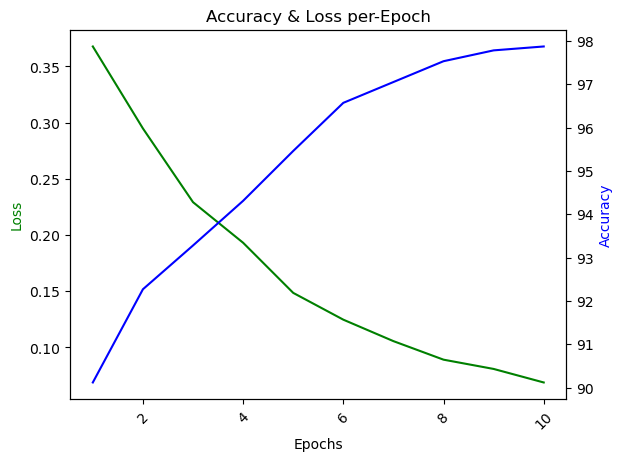

In [18]:
# To create a plot with secondary y-axis we need to create a subplot
fig, ax1 = plt.subplots()

# Set title and x-axis label rotation
plt.title("Accuracy & Loss per-Epoch")
plt.xticks(rotation=45) # Rotate label to 45 degrees

# We use twinx to create a plot a secondary y axis
ax2 = ax1.twinx() # Secondary axis on the right of the plot

# Create plot for loss_log and accuracy_log
ax1.plot(epoch_log, loss_log, 'g-') # plot loss_log for every epoch
ax2.plot(epoch_log, accuracy_log, 'b-') # plot accuracy_log for every epoch

# Set labels
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss", color='g')
ax2.set_ylabel("Accuracy", color='b')

plt.show()

# 10. Save CNN Model

In [19]:
PATH = "./models/mnist_cnn_model.pth"
torch.save(net.state_dict(), PATH)

# 11. Predict Using Loaded CNN Model

### View ground truth labels at some images from test set

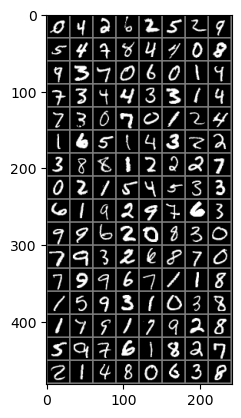

Ground Truth:  0 4 2 6 2 5 2 9 5 4 7 8 4 4 0 8 9 3 7 0 6 0 1 4 7 3 4 4 3 3 1 4 7 3 0 7 0 1 2 4 1 6 5 1 4 3 2 2 3 8 8 1 2 2 2 7 0 2 1 5 4 5 3 3 6 1 9 2 9 7 6 3 9 9 6 2 0 8 3 0 7 9 3 2 6 8 7 0 7 9 9 6 7 1 1 8 1 5 9 3 1 0 3 8 1 7 9 1 7 9 2 8 5 9 7 6 1 8 2 7 2 1 4 8 0 6 3 8 


In [20]:
# Loading one batch of images
data_iter = iter(test_loader)
images, labels = next(data_iter)

# Display images
batchshow(torchvision.utils.make_grid(images))
print("Ground Truth: ", "".join("%1s " % labels[j].numpy() for j in range(128)))

### Reload CNN model from file

In [21]:
# Create an instance of the model and move it (memory and operation) to the CUDA/Metal device
net = Net()
net.to(GPU_DEVICE)

# Load weights from the specified path
net.load_state_dict(torch.load(PATH, weights_only=True)) # for future use: set weights_only=True in torch.load

<All keys matched successfully>

### Getting predictions

Note when working with tensors on the GPU, we have to convert it back to a numpy array to perform python operations on it.

```python
your_tensor.cpu().numpy()
```

In [22]:
# Return an iterator for our train_loader object
# test_iter = iter(test_loader)

# # Get the first batch of data from our iterator
# images, labels = next(test_iter)

# batchshow(torchvision.utils.make_grid(images))

# Move this batch data to GPU
images = images.to(GPU_DEVICE)
labels = labels.to(GPU_DEVICE)

#  Forward propagate one batch
outputs = net(images)

# Get the class predictions using torch.max
_, predicted = torch.max(outputs, dim=1)

# Print our 128 predictions
print("Predicted: ", "".join("%1s " % predicted[j].cpu().numpy() for j in range(128)))

Predicted:  0 4 2 6 2 5 2 9 5 4 7 8 4 4 0 8 9 3 7 0 6 0 1 4 7 3 4 4 3 3 1 4 7 3 0 7 0 1 2 4 1 6 5 1 4 3 2 2 3 8 8 1 2 2 2 7 0 2 1 5 4 5 3 3 6 1 9 2 9 7 6 3 9 9 6 2 0 8 3 0 7 9 3 2 8 8 7 0 7 9 9 6 7 1 1 8 1 5 9 3 1 0 3 8 1 7 9 1 7 9 2 8 5 9 7 6 1 8 2 7 2 1 4 8 0 6 3 8 


### Showing our test accuracy again

In [23]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        
        # Move data to GPU
        images = images.to(GPU_DEVICE)
        labels = labels.to(GPU_DEVICE)
        
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * (correct / total)
print(f"Accuracy of the network on the 10000 test images: {accuracy:.3}%")

Accuracy of the network on the 10000 test images: 97.9%
